# AIML Assignment 2: Time Series Analysis on Pollutant Gases
## Problem Statement
![Air Pollution](https://assets.nrdc.org/sites/default/files/styles/header_background/public/health4_26_airpollguide_istock_2796602_900x600px.jpg?itok=vCwn8tgz)

Air pollution is a problem that affects major cities around the world. There are many different types of air pollutants, which usually come in the form of gases like carbon monoxide, carbon dioxide, sulfur dioxide, nitrogen oxides, CFCss, and other chemicals. 

Bad air quality in cities can lead to health problems for residents living there, including respiratory diseases and even death. In fact, according to the World Health Organisation, air pollution accounts for 4.2 million deaths every year [[1]](https://www.who.int/health-topics/air-pollution#tab=tab_1). To keep track of air pollution, governments invest heavily in sensors, which are used to measure the level of air pollution of different pollutants. However, good quality sensors are expensive, and thus governments rely on cheap sensors which have low accuracy. [[2]](https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=5536&context=sis_research)

Our task is to create a time series model that is capable of forecasting air pollution levels. If our model can forecast air pollution data with a reasonable accuracy, it would be a valuable tool (more accurate than low quality sensors) for health authorities to guage the impact of air pollution, and warn the public of any health threats. 

To be more concrete, our task is to predict the average sensor response of Carbon Monoxide, Non Metanic HydroCarbons, Nitrogen Oxides, and Ozone. (Note that sensor response is not the same as the concentration.)

### Carbon Monoxide (CO)
Carbon monoxide (CO)—a colorless, odorless, tasteless, and toxic air pollutant—is produced in the incomplete combustion of carbon-containing fuels, such as gasoline, natural gas, oil, coal, and wood. Breathing the high concentrations of CO typical of a polluted environment leads to reduced oxygen (O2) transport by hemoglobin and has health effects that include headaches, increased risk of chest pain for persons with heart disease, and impaired reaction timing. [[3]](https://www.nap.edu/read/10378/chapter/3)

## Data Understanding
The dataset appears to be sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality), but with data downsampled from an hourly frequency to a daily frequency, and several features omitted. The description and date range of the data appears to match up, the scales of the data are the same,and even the method of marking missing values is the same. Furthermore, downsampling that dataset leads to a dataset that has a similar size as the one provided. 

If we make an assumption that the data set is the same, we can say that the data was collected from chemical sensor data collected over the course of March 2004 to February 2005. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub)

![Operation of a MOS Type Gas Sensor](https://www.figaro.co.jp/en/img/development/handoutai/shikumi.gif)

The sensors used are metal oxide sensors, which use a sensing layer, where gases are either absorbed or desorbed. This reaction causes a change in the conductivity of the material. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub). The sensor device then uses this reading to estimate the concentration of that particular gas in the surroundings.

Our dataset contains the following attributes:
| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants. Note that the concentration for Carbon Monoxide would be in a different unit |

Our target attribute would be the `Value` attribute.
## References
- AIML Module Notes
- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. 
- Statsmodels Documentation
- Pandas documentation
- Scikit Learn documentation
- Wiley Data Analyst Time Series and Forecasting Notes
- [World Health Organisation](https://www.who.int/health-topics/air-pollution#tab=tab_1)
- MAAH, Balz; ZHOU, Zimu; and THIELE, Lothar. A survey on sensor calibration in air pollution monitoring 
deployments. (2018). IEEE Internet of Things. 5, (6), 4857-4870. Research Collection School Of 
Information Systems. 
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
- [S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia,
On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario](https://www.researchgate.net/publication/235641830_On_field_calibration_of_an_electronic_nose_for_benzene_estimation_in_an_urban_pollution_monitoring_scenario)
- [Climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy)
- [Nitrogen Oxide Emission Trends for Italy](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- [NOx Emissions - European Environment Agency](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)
- [Effect of Environmental Temperature and Humidity
on Different Metal Oxide Gas Sensors at Various
Gas Concentration Levels, Abdulnasser Nabil Abdullah et al 2020 IOP Conf. Ser.: Mater. Sci. Eng. 864
012152](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf)
- [Choosing the order of an ARIMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html#the-acf-and-pacf-function)
- [Using Pearson Correlation Correctly With Time Series](https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series)

## Library Imports

In [1]:
# Utility
from os import path # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models

# Statistical Analysis
## General
import numpy as np
import pandas as pd

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Data Ingestion
We will start out by loading in our data. We must take note here that the date formatting of the data does not follow the standard Pandas convention. As such, we must specify the date formatting to convert the date attribute to a datetime.

Since many Pandas time series methods only work if the index of our data is a time series, we will set the date attribute as the index.

Also, we will set all -200 values as missing values, as specified in the dataset source.

In [2]:
df = pd.read_csv("train.csv", na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df.head()

,T,RH,Gas,Value
Date,,,,
2004-03-10,12.020833,54.883334,CO,1316.500000
2004-03-11,9.833333,64.069791,CO,1244.062500
2004-03-12,11.292708,51.107292,CO,1281.562500
2004-03-13,12.866319,51.530903,CO,1330.555556
2004-03-14,16.016667,48.843750,CO,1360.927083


### Pivoting from Long to Wide Format
The form of our data is in a long format. For easier analysis later, we will pivot the data to a wide format, with a column for each row.

In [3]:
df_pivot = pd.pivot(df, values="Value", columns="Gas")
df_pivot[["T", "RH"]] = df[["T", "RH"]].groupby(df.index).mean()

## Exploratory Data Analysis

We then perform an exploratory data analysis of our data. 

### What do we want to find out?
#### General Dataset Information
- How many rows of data are there?
- What is the frequency of the time series data?
- How many features are there, and what do they mean?
- What are the data types of each attribute, and are they correctly represented?

#### Missing Values
- How many missing values are there?
- Why are there missing values?
- What should be done about the missing values?

#### Distribution of Data
- What does the distribution of our data look like, and what does it say about the data?

#### Outlier Analysis
- How many outliers are there in the data?
- Where are the outliers in the data?
- What should be done about outliers?
#### Correlation
- What are the relationships between the various variables?

#### Time Series

- What can be said about the trend and seasonality of the data?
- Is the data stationary?

### General Dataset Information

#### How many rows of data are there?

In [4]:
rows, cols = df.shape
print(f"There are {rows} rows and {cols} attributes in the dataset.")

There are 1312 rows and 4 attributes in the dataset.


In [5]:
rows, cols = df_pivot.shape
print(f"There are {rows} rows and {cols} attributes in the pivoted dataset.")

There are 328 rows and 6 attributes in the pivoted dataset.


#### What is the frequency of the time series data?

In [9]:
df_pivot.index

DatetimeIndex(['2004-03-10', '2004-03-11', '2004-03-12', '2004-03-13',
               '2004-03-14', '2004-03-15', '2004-03-16', '2004-03-17',
               '2004-03-18', '2004-03-19',
               ...
               '2005-01-22', '2005-01-23', '2005-01-24', '2005-01-25',
               '2005-01-26', '2005-01-27', '2005-01-28', '2005-01-29',
               '2005-01-30', '2005-01-31'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

There is not explicitly stated frequency. However, we suspect it is daily. We will need to verify this.

In [10]:
len(df_pivot) - len(df_pivot.asfreq("D"))

0

Since `.asfreq("D")` did not make any extra rows in the data, this confirms our hypothesis of a daily frequency.

In [11]:
df_pivot = df_pivot.asfreq("D") # explicitly state a daily frequency

#### How many features are there and what do they mean?

Our dataset contains the following attributes:
| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants in micrograms/milligrams per cubic meter. Note that the concentration for Carbon Monoxide would be in a different unit (milligrams) |

#### What are the data types of each attribute, and are they correctly represented?

In [13]:
df.dtypes

T        float64
RH       float64
Gas       object
Value    float64
dtype: object

We observe no irregularities with regards to the data type.

### Missing Values

#### How many missing values are there?

In [14]:
df.isna().sum()

T        24
RH       24
Gas       0
Value    24
dtype: int64

In [15]:
df_pivot.isna().sum()

Gas
CO      6
NMHC    6
NOx     6
O3      6
T       6
RH      6
dtype: int64

In [16]:
df_pivot.isna().all(axis=1).sum()

6

It appears that there are exactly six days, where all the attributes are missing.

In [17]:
(df_pivot.isna().all(axis=1).sum() / len(df_pivot)) * 100

1.8292682926829267

This constitutes a very small percentage of our data.

#### Why are there missing values?

In [20]:
df_pivot[df_pivot.isna().any(axis=1)]

Gas,CO,NMHC,NOx,O3,T,RH
Date,,,,,,
2004-06-20,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-27,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-15,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-16,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,NaN,NaN,NaN,NaN,NaN,NaN


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

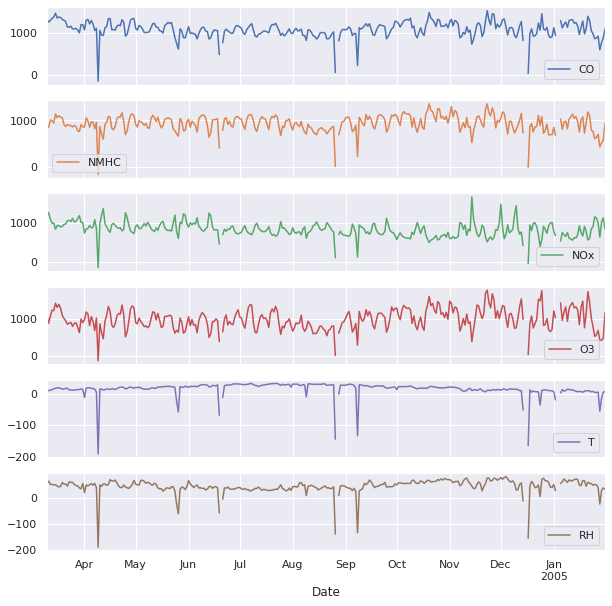

In [26]:
df_pivot.plot(subplots=True, figsize=(10, 10))

We note that days where the missing values do not appear to be related. For some of the days with missing values, we note that the days before and after them have some extreme values, such as extreme spikes.

One possible hypothesis is that the spikes indicate some problem with the sensor used, and thus, the sensors had to be sent for repairs, causing data to be unavailable in the meantime. This would indicate why all the sensors had missing datas on those days.

#### What should be done about missing values?

Based on our hypothesis, if the missing values are due to problems with the sensors that were detected, it may not be a good idea to immediately fill the missing values with the previous value, as it may be an outlier value.

Possible methods:
- Front fill, but mark and deal with outliers first

### Distribution of Data

#### What does the distribution of our data look like, and what does it say about the data?

In [27]:
df_pivot.describe()

Gas,CO,NMHC,NOx,O3,T,RH
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,1074.034862,932.706457,831.478477,997.677396,15.578425,44.343425
std,192.346012,184.942814,200.428180,287.769529,23.412864,28.487081
min,-142.666667,-153.458333,-155.583333,-143.697917,-191.164583,-188.839583
25%,981.338542,839.421875,712.370660,809.098958,12.627083,37.101042
50%,1084.482639,948.649306,826.208333,1005.692708,18.993750,46.452083
75%,1188.539062,1061.109375,944.387153,1183.658854,25.714149,58.028386
max,1513.208333,1355.104167,1678.687500,1795.291667,32.997917,81.104167


- The mean temperature recorded is 15.57 Degrees Celcius, but the min temperature -191.164 degrees celcius. This appears to be an extreme outlier.
- The median temperature is higher than the mean temperature, suggesting a negatively skewed distribution.
- The temperatures seen are mostly consistent with the [climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy). This suggests that the temperatures with extreme negative values are actually outliers (possibly sensor miscalibrations), and not the result of extreme cooling in the sensor device.
- The mean relative humidity is 44.34%, which is lower than the median relative humidity. This might suggest a negatively skewed distribution of the data.
- If relative humidity is in percentage, having a negative percentage relative humidity does not make sense. Consider that relative humidity is the **ratio of how much water vapour is in the air and how much water vapor the air could possibly contain at a given temperature**; How is it possible then that it is negative? Logically this must be an error (again, possibly a result of faulty sensors), and any negative values for Relative Humidity should be removed.
- Furthermore, according to the researchers who collected the data, the sensors used are only rated for a temperature of -20 to 50 degrees celcius, and a relative humidity of 10% to 90%. Hence, it is safe to consider any values out of this range as being inaccurate anyways.

![sensor specifications](sensor_specifications.png)

- In our data, we see that there are negative values for each gas as their min estimated concentration
- Recall that for the metal oxide sensors used to collect this data, we get these readings by measuring the change in resistance of the metal oxide material due to a chemical reaction between the metal oxide and the gas and using it to estimate the concentration of pollutants. Thus the "value" attribute in our data is supposed to be an estimated concentration in $\mu/m^3$ (for Nitrogen Oxides and Ozone), or $mg/m^3$ (for Carbon Monoxide)
- As such, a negative concentration does not make any sense. Given that the sensor is only giving a rough estimate of the concentration, it is highly possible that these negative values came about due to sensor errors. 
- The mean values are similar to their median, suggesting that the distribution is not highly skewed; The only outliers come from the negative values.
- Since the values are technically in different units, we may also want to perform scaling of our data.

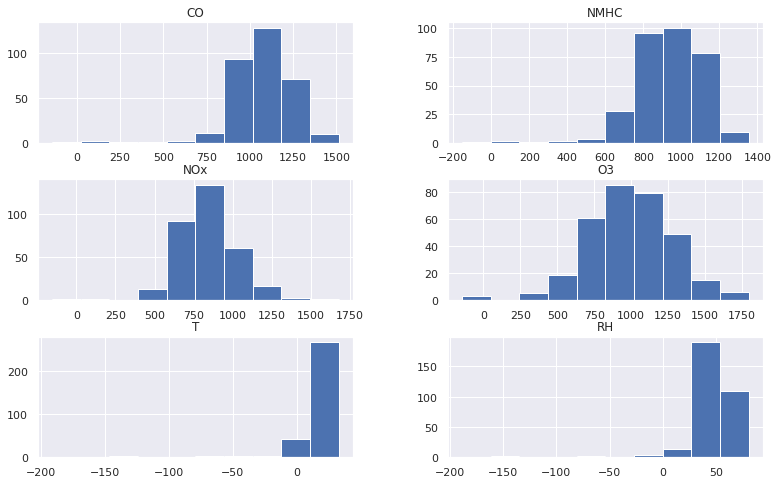

In [29]:
df_pivot.hist()
plt.show()

- We observe that the distribution of Temperature and Relative Humidity is negatively skewed, due to the outlier values
- The distribution of NOx and O3 appear to be more symmetrical
- Distribution of CO and NMHC is more negatively skewed, due to there being some outlier values.

### Outlier Analysis

From our previous analysis, we noted the presense of outliers in all numerical features. We had already come to a few conclusions based on our background research:
- These values are unnatural, and are impossible occurances in real life:
    - The freezing outlier temps are too cold for Italy's, and even too cold for the Artic
    - It is impossible for relative humidity to be negative
    - The sensors used to collect the data, are not rated for these extreme outlier temperatures/humdity
    - A negative concentration (which is what the sensors are trying to estimate), is also ridiculous. 
- Thus, we hypothesise that these come as a result of sensor calibration errors, resulting in a wrong sensor reading.

To test this hypothesis, we want to answer a few questions:
1. How many of these extreme outliers are there?
2. When do these outliers happen? Do they happen indepedently, or is there some pattern to the outlier data?

For this, we will use Tukey's Fences to denote any outliers. Recall that by this criterion, an outlier is any data that founds outside the range $[Q_1 - k(Q_3 - Q_1), Q_3 + k(Q_3 - Q_1)]$. We use Tukey's Fences, as this method is applicable to skewed data since it makes no distributional assumptions and it does not depend on a mean or standard 
deviation. In this case, we will look at the extreme outliers, setting $k=3$. We will also mark negative RH and Value as outliers, since in the context here, they are definitely wrong.

We also need to take note that for time series data, we cannot use future information to detect past outliers. Hence, we will detect outliers on a rolling basis.

In [75]:
df_outliers = df_pivot.copy()

In [48]:
def mark_outliers(df, col, k=1.5, window=7):
    df_col = df[col].rolling(window)
    upper_quartile = df_col.quantile(.75)
    lower_quartile = df_col.quantile(.25)
    interquartille_range = upper_quartile - lower_quartile
    upper_fence = upper_quartile + (k * interquartille_range)
    lower_fence = lower_quartile - (k * interquartille_range)
    outliers = ~(df[col].between(lower_fence, upper_fence))
    return outliers

Our current outlier detection method also may miss out certain anomalies.

We want to ensure that any 'impossible' values are marked as outliers. These are values which could not possibly be 0, or are actually out of the operating range for the sensor, and thus the result may not be reliable.

In [76]:
additional_outlier_rules = {
        col : df_outliers[col] < 0 for col in ('CO', 'NMHC', 'NOx', 'O3')
} | {
    "T" : (df_outliers['T'] < -20) | (df_outliers['T'] > 50),
    "RH" : (df_outliers['RH'] < 10) | (df_outliers['RH'] > 90)
}

In [77]:
for col in df_outliers.columns:
    outliers = mark_outliers(df_outliers, col, k=3, window=7) # 1 Week Window
    df_outliers[f'Outlier ({col})'] = (outliers) | (additional_outlier_rules[col])
    

In [78]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].any(axis=1).sum()

72

In [79]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].sum()

Gas
Outlier (CO)      43
Outlier (NMHC)    42
Outlier (NOx)     49
Outlier (O3)      41
Outlier (T)       57
Outlier (RH)      51
dtype: int64

There are 72 rows with at least one outlier in total. Since there are at least >40 outliers for each column, it suggests that most days with outliers have more than one attribute with an outlier.

#### Where are the outliers in the data?

In [60]:
def plot_outlier(df, col_name, ax):
    outliers = df_outliers[df_outliers[f'Outlier ({col_name})'] == True]
    print(f"Number of Outliers for {col}:", len(outliers))
    df_outliers.plot(y=col_name, title=f"Outlier Plot of {col_name}", ax = ax)
    ax.scatter(x=outliers.index, y=outliers[col_name], color='r')

Number of Outliers for CO: 43
Number of Outliers for NMHC: 42
Number of Outliers for NOx: 49
Number of Outliers for O3: 41
Number of Outliers for T: 57
Number of Outliers for RH: 51


<ipython-input-61-43aa801458d2>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


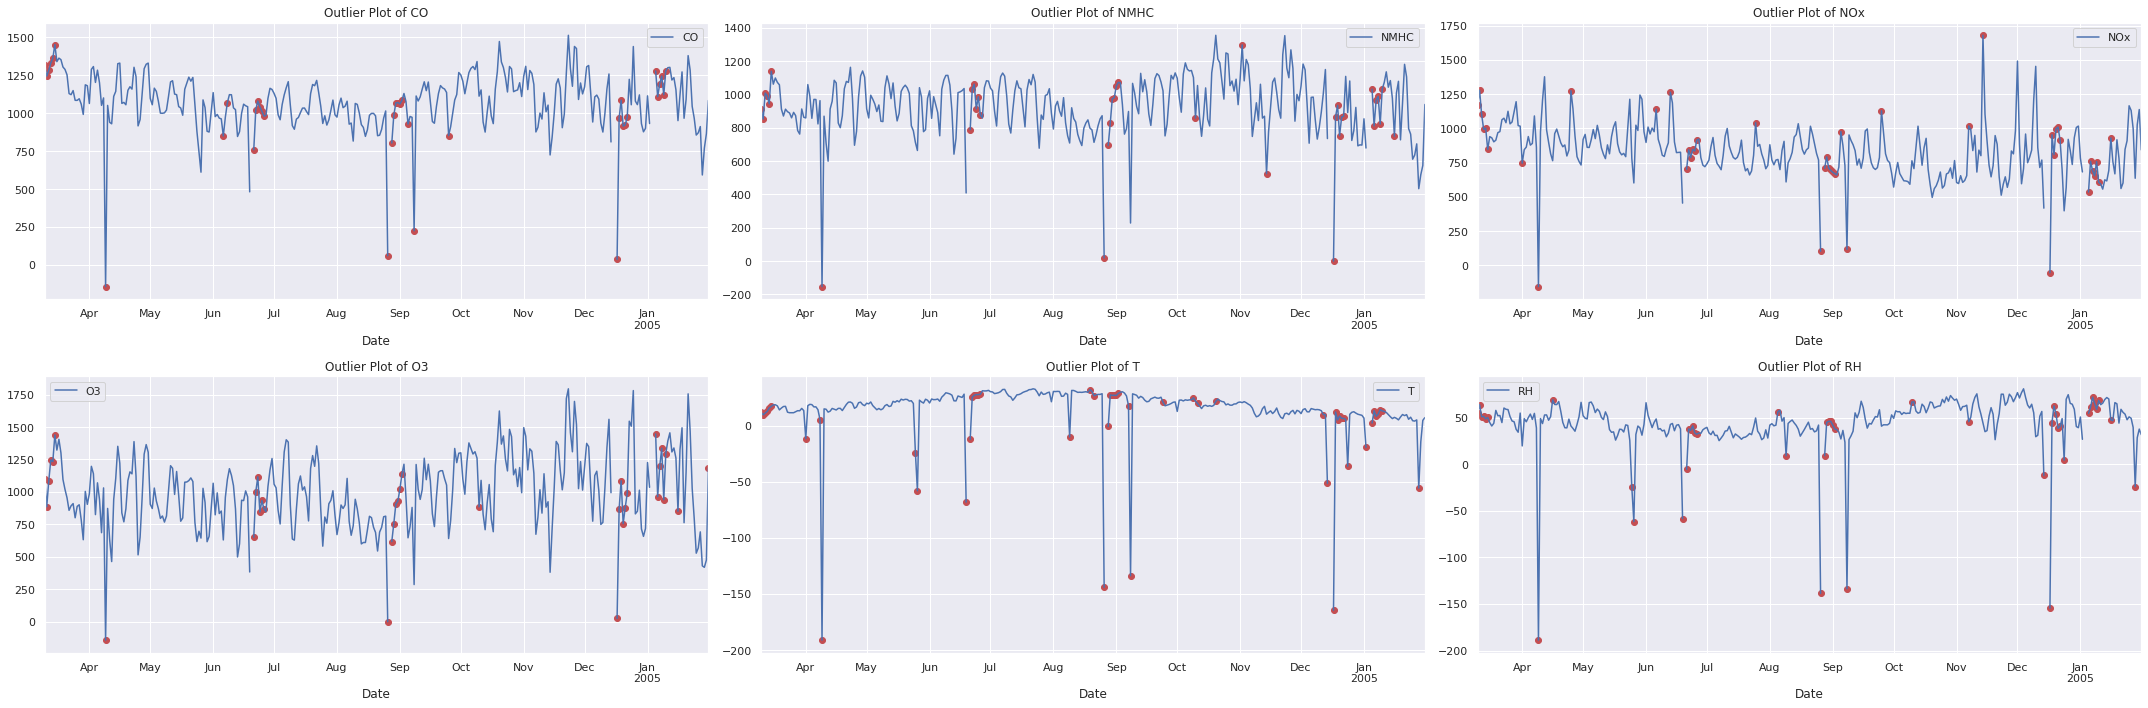

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(30, 10), tight_layout=True)

for ax, col in zip(axes.ravel(), df_pivot.columns):
    plot_outlier(df_outliers, col, ax)

fig.show()

- We note that the detected outliers appear to happen at similar points in time to outliers in other features

#### What should be done about outliers?

According to [research](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf), when there are changes in the temperature and relative humidity, it causes a change in the resistance of the sensor, thus causing the readings to drift. This suggest that outside of the operating range of the sensors used (-20 to 50 degrees in Temp, and 10-90% relative humidity), the readings of the sensor would be less accurate. 

There are a few approaches we can take here:
- Ignore the outliers. But this is likely a bad idea, as at the very least, the outlier temperature and relative humidity are definitely wrong.
- Mark the outlier value, and  
    - Impute with the previous value
    - Impute with a rolling mean

For a start, we will mark the outlier value and replace it with the previous value. For those where there are no previous value, we will fill it with the next value (which does unfortunately cause some data leakage, but it will be relatively minor)

In [81]:
df_outliers.sum(axis=0)

Gas
CO                345839.225691
NMHC              300331.479173
NOx               267736.069443
O3                321252.121517
T                   5016.252777
RH                 14278.582988
Outlier (CO)          43.000000
Outlier (NMHC)        42.000000
Outlier (NOx)         49.000000
Outlier (O3)          41.000000
Outlier (T)           57.000000
Outlier (RH)          51.000000
dtype: float64

In [98]:
df_clean = df_outliers.copy()
for col in df_pivot.columns:
    df_clean.loc[df_clean[f'Outlier ({col})'], col] = np.nan
print(df_clean.isna().sum())
df_clean = df_clean.ffill().bfill()
df_clean = df_clean[['CO', 'NMHC', 'NOx', 'O3', 'T', 'RH']]
print(df_clean.isna().sum())


Gas
CO                43
NMHC              42
NOx               49
O3                41
T                 57
RH                51
Outlier (CO)       0
Outlier (NMHC)     0
Outlier (NOx)      0
Outlier (O3)       0
Outlier (T)        0
Outlier (RH)       0
dtype: int64
Gas
CO      0
NMHC    0
NOx     0
O3      0
T       0
RH      0
dtype: int64


### Correlation
#### What are the relationships between the various variables?

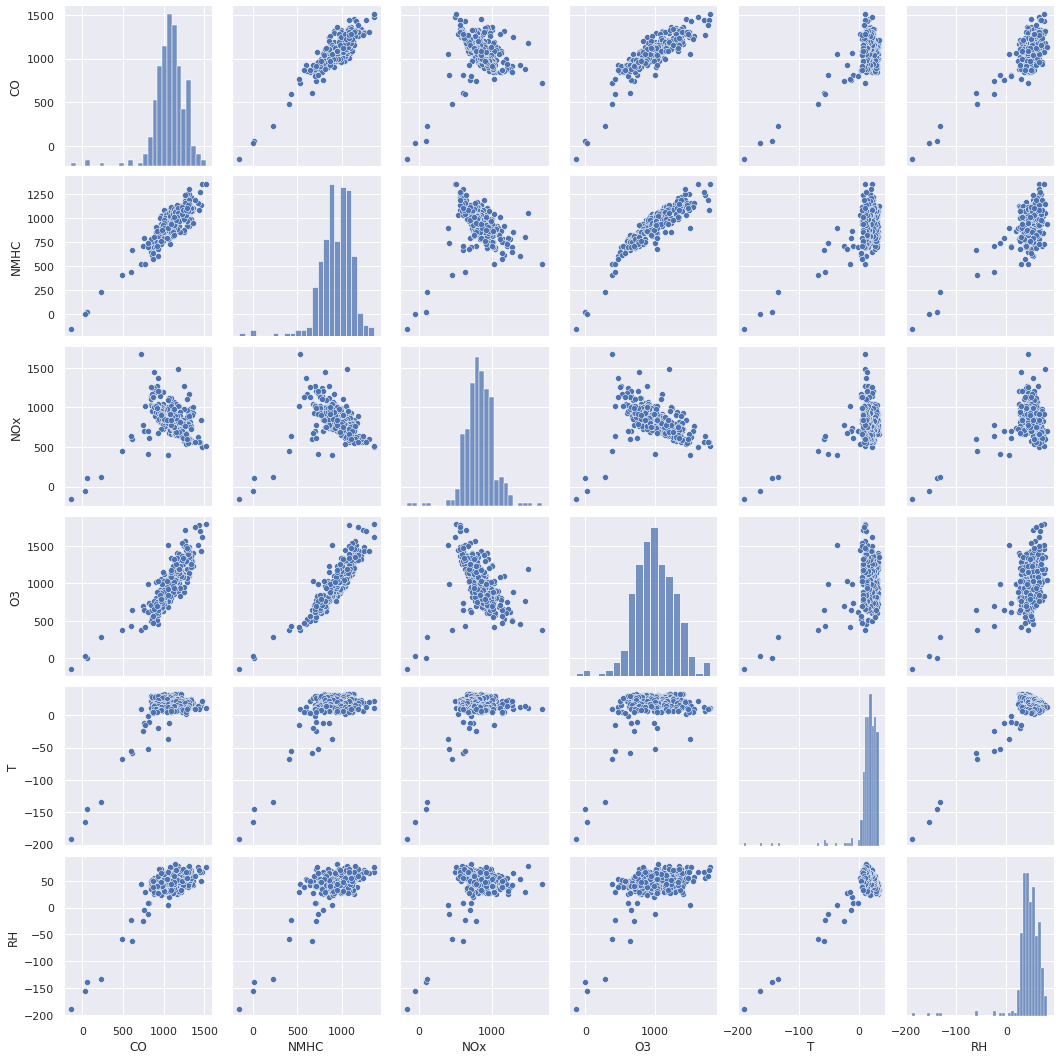

In [62]:
sns.pairplot(df_pivot)

We see that before we cleaned the data, there were many outliers, which do not follow the trend of the data.

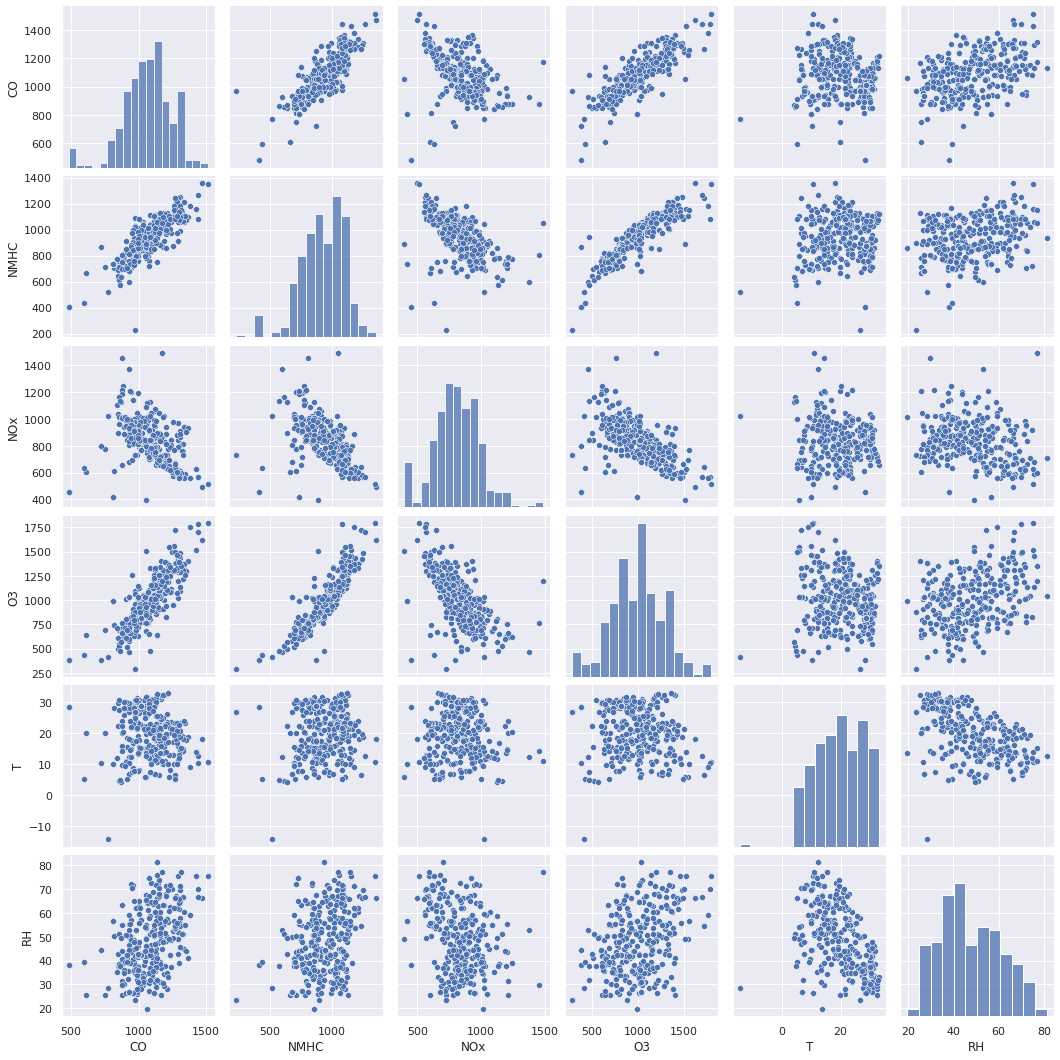

In [99]:
sns.pairplot(df_clean)

To avoid recording spurious correlation (false correlation due to within-series dependence), we will instead calculate correlation based off the percentage change (the differenced data).

To calculate correlation, we use Pearson's correlation coefficient.

<AxesSubplot:xlabel='Gas', ylabel='Gas'>

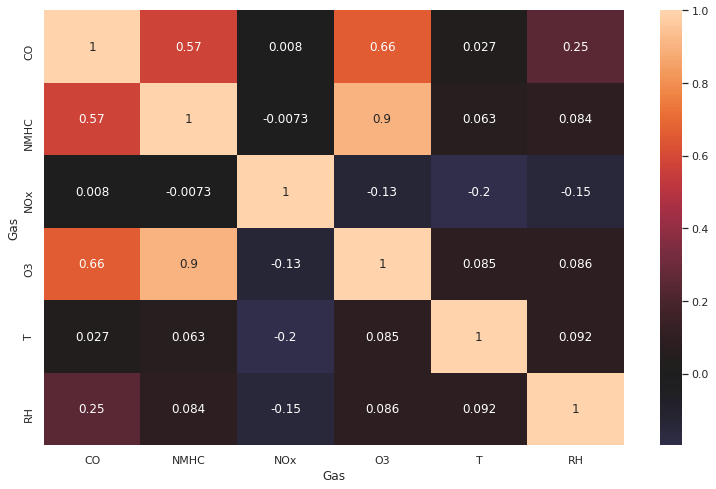

In [107]:
sns.heatmap(df_clean.pct_change().corr(), annot=True, center=0)

- We observe that the change in CO levels is highly correlated with the change in Ozone (r=0.66) and NMHC (r=0.57) levels 

- The change in NMHC is strongly correlated with the change in Ozone (r=0.9)
- Changes in the concentration of NOx does not appear to be highly correlated with the changes in other gases.

### Time Series

#### What can be said about the trend and seasonality of the data?

To have a clearer understanding of our data, we want to decompose the time series into it's components, which are: the Seasonal Component ($S_t$), the Trend-Cycle component ($T_t$), and the remainder components ($R_t$)

There are two ways which we can decompose our data, additively ($y_t = S_t + T_t + R_t$), or multiplicatively ($y_t = S_t \times T_t \times R_t$). Given that for most our our time series data (except that of Relative Humidity), the variance does not change as the mean changes, an additive model for decomposition makes the most sense. 

To decompose the data, we will use STL decomposition, due to it's advantages over classical decomposition methods. (it allows for the seasonal component to change over time, and is robust to outliers, which is important given that we showed earlier that unusual observations exist in the data). 

##### Temperature (T)

In [109]:
px.line(data_frame=df_clean, y='T')

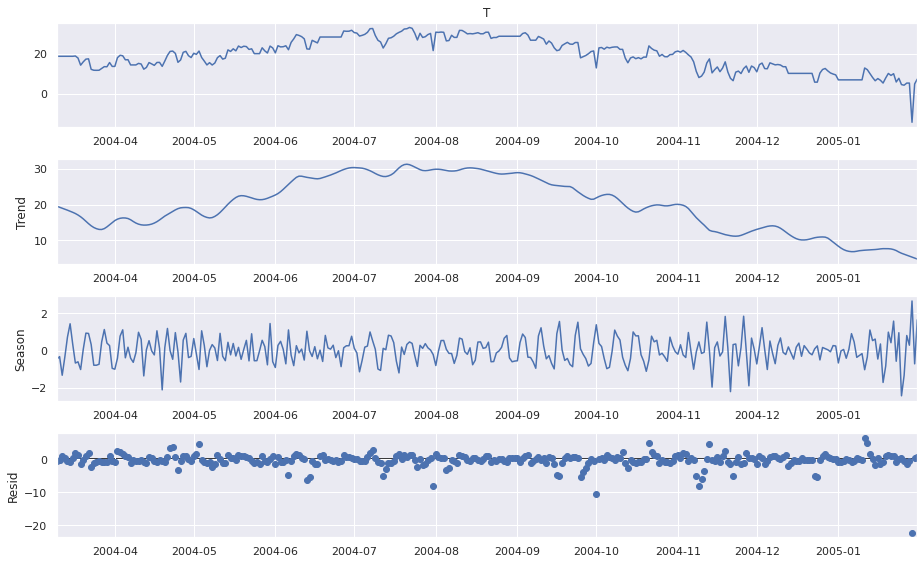

In [108]:
res = STL(df_clean['T'], robust=True).fit()
res.plot()
plt.show()

- There is a upward non-linear trend in temperature from April to August, before the trend changes direction to become downwards. 
- The seasonality in the data does not appear to be very strong, and seems inconsistent.
- The temperature peaked between the months of June and September, where temperature was between 20 to 30 degrees celcius. The peak temperatures occured in July, where some days were above 30 degrees.
- The temperature is the lowest during the start of the year and near the end of the year, which are during the Winter season.
- The mean temperature does not remain constant through the year, but the variance appears to remain constant through the year.

##### Relative Humidity (RH)

In [110]:
px.line(data_frame=df_clean, y='RH')

We note that the variance of the relative humidity appears to increase when the relative humidity increases. This suggests a multiplicative decomposition of the data is appropriate. Since STL decomposition is only additive, we will use classical decomposition methods for this feature.

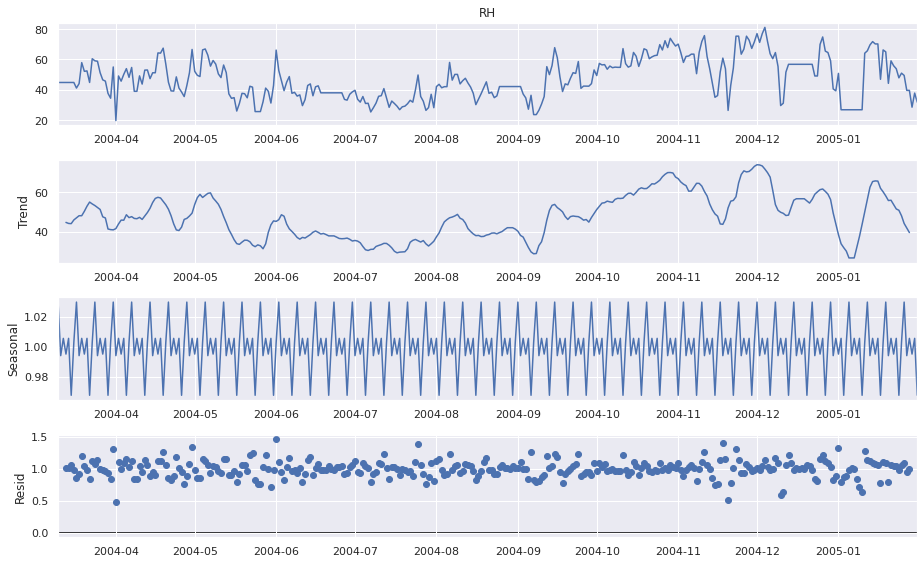

In [111]:
res = seasonal_decompose(df_clean['RH'], 'multiplicative')
res.plot()
plt.show()

- There is a downward trend in relative humidity from April to August, before the trend changes direction to become downwards. The trend appears to be non-linear.
- It is clear that there is strong seasonality in the data, as even the trend appears to follow the seasonality after it is decomposed.
- The mean and variance of the relative humidity do not appear to be constant throughout the year, as the mean and variance of relative humidity appears to be lower during the months of June to September.
- This period of low humidity corresponds to a period of the highest temperatures of the year. This makes sense as **relative humidity is inversely proportional to temperature**
- Thus, the peak period of high relative humidity is also during the coldest parts of the year, during the end and the start of the year.

##### Carbon Monoxide (CO)

In [112]:
px.line(data_frame=df_clean, y='CO')

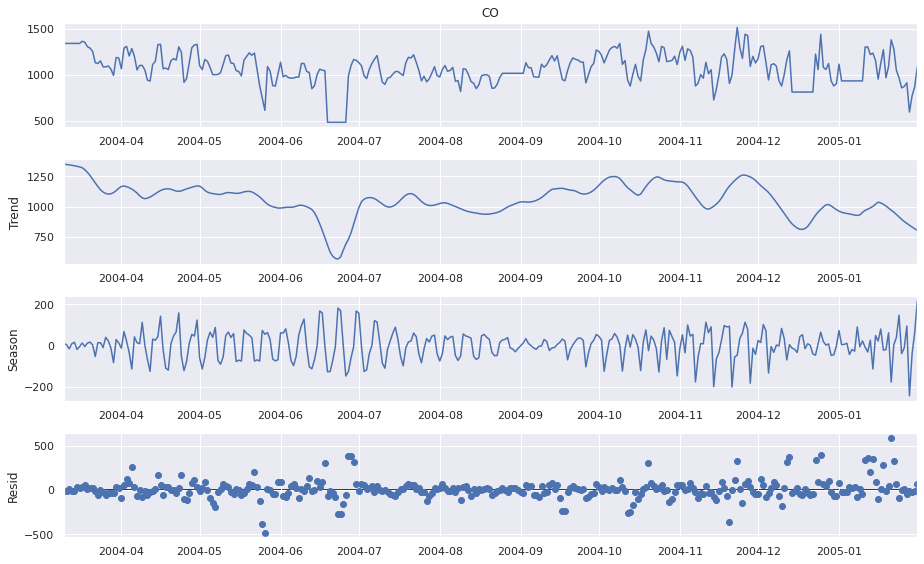

In [114]:
res = STL(df_clean['CO'], robust=True).fit()
res.plot()
plt.show()

- The concentration of CO has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005 (but the trend becomes weaker nearing the end of the year)
- There is a seasonality in the data, that appears to repeat every week, where the concentration rises and falls. This could correspond to increased edmissions during the weekdays compared to weekends.
- The concentration of Carbon Monoxide appears to have a constant mean and variance, suggesting that it is stationary.
- On Weekends, it seems that CO concentration is lower, but this requires further statistical testing to verify. This could potentially be due to human sources of CO like vehicle emissions being lower when people are not working, and thus commuting less. 

##### Non-methane Hydrocarbons (NMHC)

In [115]:
px.line(data_frame=df_clean, y='NMHC')

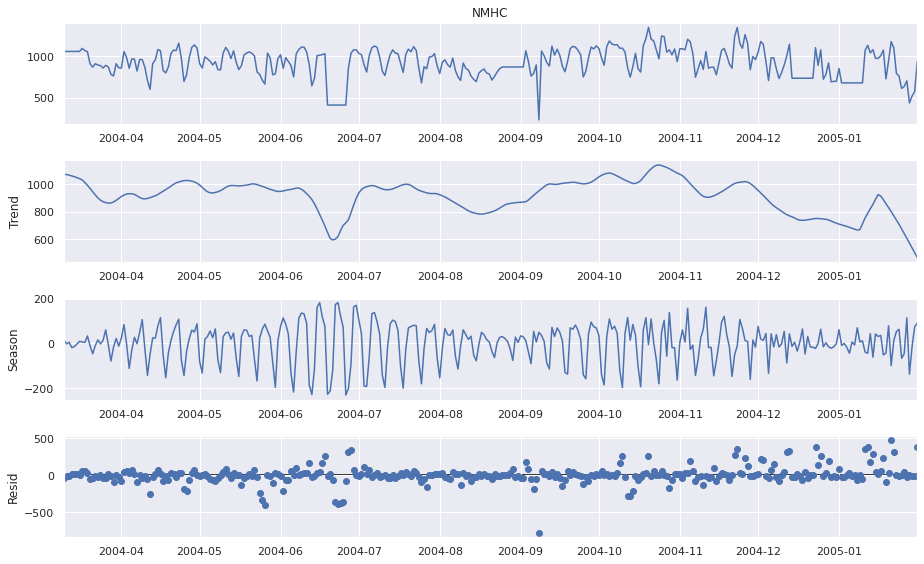

In [116]:
res = STL(df_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- The trend for NMHC is very weak, and does not appear to change significantly
- The seasonality is much stronger, with there being a cycle that seemingly corresponds to each week.
- Similarily to that for CO, emissions of NMHC appear to be much lower during the weekends.
- One reason for this is that NMHC is also emitted via human sources like vehicle exhaust, chemical manufacturing and energy production, which might decrease during the weekend, when there is less human activity.

##### Nitrogen Oxides

In [117]:
px.line(data_frame=df_clean, y='NOx')

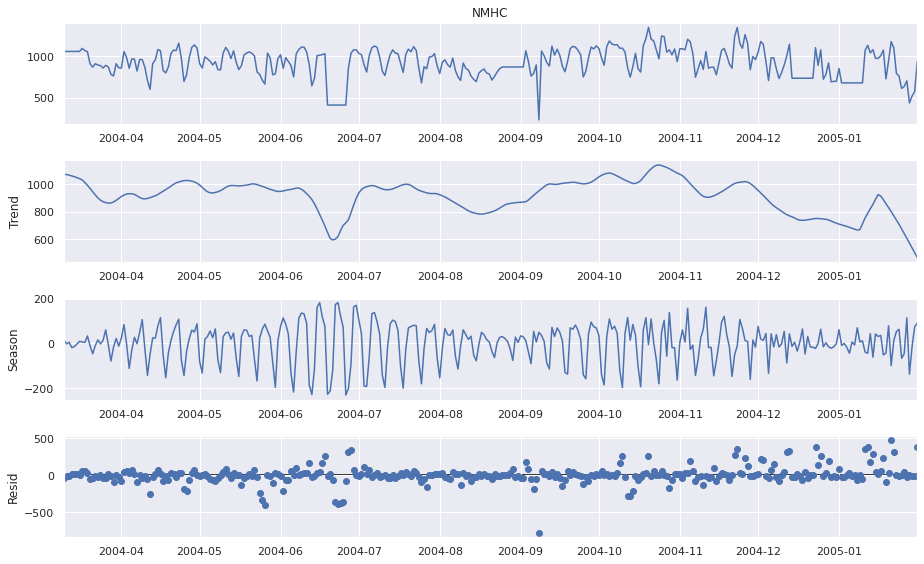

In [118]:
res = STL(df_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- For NOx concentrations, the time series does not appear to be stationary, as the mean and variance vary slightly
- There appears to be a small downward trend in the data
- There is a non-linear downward trend between April 2004 to November 2004, before changing directions to an upward trend from December 2004 to January 2001. This suggests that emissions of Nitrogen Oxides have been decreasing over time.
- This is corroborated by referencing the emission trend of Nitrogen oxides in Italy, where there has been a sharp decrease in NOx emissions fromm 2000 to 2018. [Source](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- According to the European Environment Agency, this is due to the installation of catalysts to vehicles during this period as per new EU standards, resulting in lower NOx emissions from vehicles. (47% of the reduction in NOx emissions from 1990 and 2011 come from vehicle emissions)  [Source](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)

##### Ozone (O3)

In [120]:
px.line(data_frame=df_clean, y='O3')

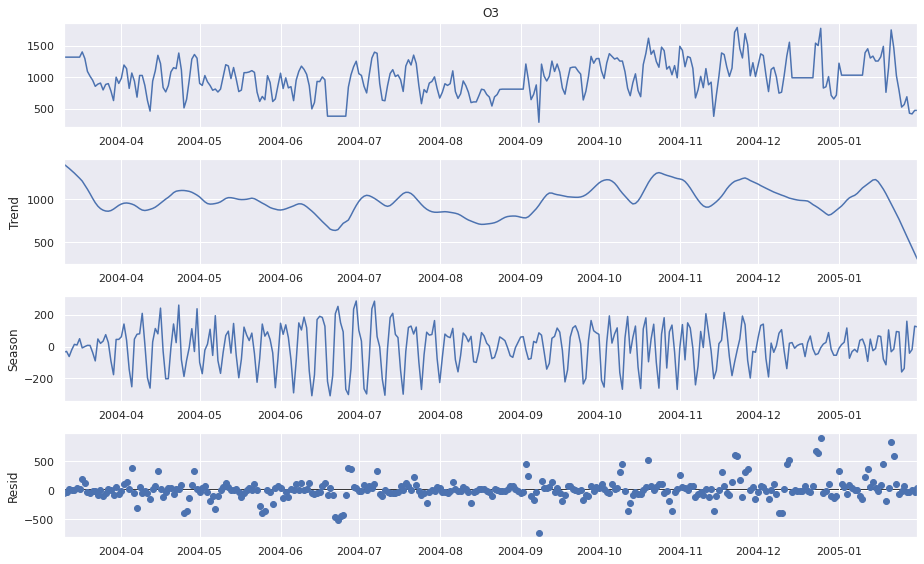

In [121]:
res = STL(df_clean['O3'], robust=True).fit()
res.plot()
plt.show()

- The concentration of Ozone has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005.
- The time series appears to have a constant mean, but there is some variation in the variance, such as during the start of the year.
- According to the US Environmental Protection Agency,ground level ozone, is not emitted directly into the air, but is created by chemical reactions between oxides of nitrogen (NOx) and volatile organic compounds (VOC). This happens when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight.
- This may explain why the highest levels of Ozone are also the periods of time in which NOx levels are the highest (November to January)
- Strangely, this period is also very cold, and low temperatures should cause levels of Ozone to become lower. Hence it is likely that the increase in Ozone is due to the higher levels of NOx

##### Strength of Trend and Seasonality
It is useful for us to know how strong trend and seasonality are in our time series data, for later model selection and improvement.

[For strongly trended data, the seasonally adjusted data should have much more variation than the remainder component.](https://otexts.com/fpp2/seasonal-strength.html) Therefore $Var(R_t)/Var(T_t+R_t)$ should be relatively small. But for data with little or no trend, the two variances should be approximately the same. So the strength of trend is defined as
$$
F_t = \max (0, 1 - \frac{Var(R_t)}{Var(T_t + R_t)})
$$

Similarily, we define the strength of seasonality as
$$

F_s = \max (0, 1 - \frac{Var(R_t)}{Var(S_t + R_t)})

$$

In [122]:
trends, seasonality, residuals = [], [], []
for feature in df_clean.columns:
    decomposition = STL(df_clean[feature], robust=True).fit()
    trends.append(decomposition.trend)
    seasonality.append(decomposition.seasonal)
    residuals.append(decomposition.resid)

decompose_df = pd.DataFrame({
    "Var_Trend" : [trend.var() for trend in trends],
    "Var_Seasonality + Residual" : [(season + resid).var() for season, resid in zip(seasonality, residuals)],
    "Var_Trend + Residual" : [(trend + resid).var() for trend, resid in zip(trends, residuals)],
    "Var_Residuals":  [resid.var() for resid in residuals],
}, index = df_clean.columns)
decompose_df['Trend Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Trend + Residual'])), axis = 1)
decompose_df['Seasonal Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Seasonality + Residual'])), axis = 1)

decompose_df

,Var_Trend,Var_Seasonality + Residual,Var_Trend + Residual,Var_Residuals,Trend Strength,Seasonal Strength
Gas,,,,,,
CO,17982.823584,14363.679234,29724.296287,12491.260314,0.579763,0.130358
NMHC,15269.714169,18815.297485,27747.643805,14793.860661,0.466843,0.213732
NOx,14127.130888,16874.159100,30978.304721,15833.034290,0.488899,0.061699
O3,28174.120231,43808.812438,70406.777930,33880.965902,0.518783,0.226618
T,56.440353,4.696003,61.957953,4.729431,0.923667,0.000000
RH,107.066410,58.563407,175.261299,55.222586,0.684913,0.057046


- We see that out of all of the gases, Ozone has the strongest trend and Seasonality, whilst Carbon Monoxide has a strong trend but weak seasonality

### Is the Data Stationary?

Before we can engage in modelling, we need to check if our data satisfies certain statistical assumptions that may be made by our models (ARIMA models). This will inform us if further pre-processing is needed. (e.g Differencing is required for our data).

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. 

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

[Source](https://otexts.com/fpp3/stationarity.html)

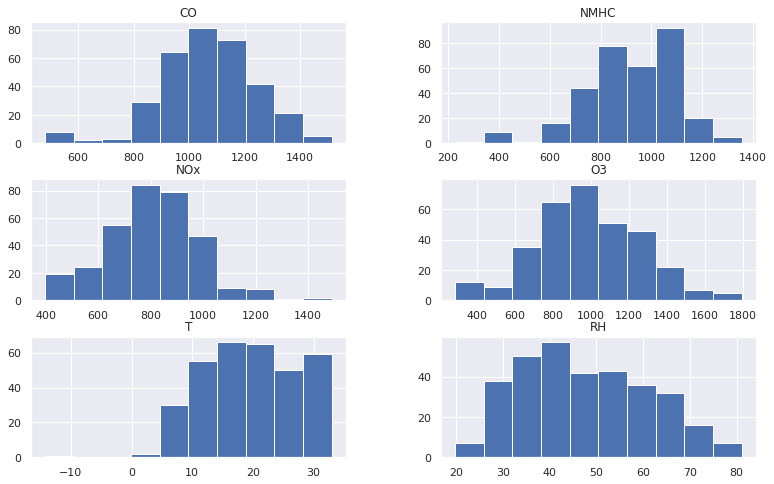

In [124]:
df_clean.hist()
plt.show()

- On a first inspection, it appears that O3 and CO are stationary as they look normally distributed

In [130]:
grp1 = df_clean[:len(df_clean) // 2]
grp2 = df_clean[len(df_clean) // 2:]

pd.concat([grp1.describe(), grp2.describe()], axis = 1, keys=["Grp1", "Grp2"]).T

count         mean         std         min         25%  \
     Gas                                                            
Grp1 CO    164.0  1052.619665  185.838796  481.753472  981.184896   
     NMHC  164.0   910.767658  166.735275  408.704861  829.156250   
     NOx   164.0   870.292768  157.245057  453.715278  791.588542   
     O3    164.0   925.152820  248.592195  382.131944  771.890625   
     T     164.0    22.991819    6.209747   11.630208   17.944010   
     RH    164.0    42.267668    9.954528   19.742014   35.580989   
Grp2 CO    164.0  1079.086149  167.746647  592.864583  939.372396   
     NMHC  164.0   933.873264  188.195154  228.187500  791.626736   
     NOx   164.0   750.526994  180.120317  397.343750  644.192708   
     O3    164.0  1064.509570  295.920494  285.010417  823.252604   
     T     164.0    16.133412    7.842304  -14.272917   10.103125   
     RH    164.0    52.851374   14.255696   23.669792   42.145833   

                   50%          75%          max  
     Gas                                          
Grp1 CO    1057.585069  1158.091146  1362.708333  
     NMHC   930.397569  1040.486979  1163.041667  
     NOx    870.453125   954.494792  1376.031250  
     O3     914.328125  1090.419271  1405.677083  
     T       22.773958    28.783594    32.997917  
     RH      41.373785    48.720052    67.430556  
Grp2 CO    1090.138889  1198.651042  1513.208333  
     NMHC   938.848958  1089.131076  1355.104167  
     NOx    729.286458   841.203125  1490.281250  
     O3    1035.302083  1260.510417  1795.291667  
     T       15.263542    22.590191    30.625000  
     RH      55.313715    64.193490    81.104167

- The mean values for Grp 1 and 2 are similar for CO, NMHC, suggesting they are stationary

To tell more concretely if our data is stationary, we will conduct two tests, an Augmented Dickey Fuller Test, and a KPSS test.

##### ADF Test
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis failed to be rejected, this test may provide evidence that the series is non-stationary.

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [132]:
def adf_test(series, significance_level = 0.05):
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: There is a unit root (non-stationary time series)\nH1: There is no unit root (stationary time series)")
    test_statistic, pvalue, usedlag, *_ = adfuller(series)
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    return test_statistic, pvalue, usedlag

In [134]:
for gas in df_clean.columns:
    print(gas)
    adf_test(df_clean[gas])

CO
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 1
Reject H0. There is evidence that the time series is stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.017
Used Lag: 16
Reject H0. There is evidence that the time series is stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 2
Reject H0. There is evidence that the time series is stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 7
Reject H0. There is evidence that the time series is stationary.
T
Test f

- According to the ADF test, all of the gas time series are stationary

##### KPSS Test
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

We apply this test in addition to the ADF test, to ensure that our data is truly stationary.

In [135]:
def kpss_test(series, significance_level = 0.05):
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary\nH1: There is a unit root (non-stationary)")
    test_statistic, pvalue, usedlag, *_ = kpss(series, regression="c", nlags="auto")
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is not stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
    return test_statistic, pvalue, usedlag

In [137]:
for gas in df_clean.columns:
    print(gas)
    kpss_test(df_clean[gas])

CO
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 9
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 9
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 9
Reject H0. There is evidence that the time series is not stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.031
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.
T
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stati

/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in th

For O3 and NOx, we note that KPSS indicates the data is non-stationary, but the ADF test indicates it is stationary. The series is thus inferred to be difference stationary. 

We will difference the data, and check the differenced data for stationarity.

In [139]:
print("Results of KPSS Test on Differenced Series (O3)")
kpss_test(diff(df_clean['O3']))

print("Results of ADF Test on Differenced Series (O3)")
adf_test(diff(df_clean['O3']))

print("Results of KPSS Test on Differenced Series (NOx)")
kpss_test(diff(df_clean['NOx']))


print("Results of ADF Test on Differenced Series (NOx)")
adf_test(diff(df_clean['NOx']))

Results of KPSS Test on Differenced Series (O3)
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 53
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
Results of ADF Test on Differenced Series (O3)
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 17
Reject H0. There is evidence that the time series is stationary.
Results of KPSS Test on Differenced Series (NOx)
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 30
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
Results of ADF Test on Differenced Series (NOx)
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationa

/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/home/tiencheng/mambaforge/envs/aiml/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(-11.485338222263685, 4.8812250295296594e-21, 4)

We observe that after detrending via differencing, the KPSS test shows that O3 and NOx are now truly stationary.

## Data Pre-processing
Now, we will proceed to process our data. This will involve transforming our data, and dealing with missing values and outliers.

In [140]:
def DataPreprocess(dataset, train = True, impute=True, remove_outliers=True):
    missing_days = pd.isnull(dataset).any(axis=1)
    basic_outlier_rules = {
    "T" : (dataset['T'] < -20) | (dataset['T'] > 50),
    "RH" : (dataset['RH'] < 10) | (dataset['RH'] > 90)
}
    if remove_outliers:
        dataset.loc[basic_outlier_rules['T'], 'T'] = np.nan
        dataset.loc[basic_outlier_rules['RH'], 'RH'] = np.nan
        if train:
            additional_outlier_rules = {
            col : dataset[col] < 0 for col in ('CO', 'NMHC', 'NOx', 'O3')
    } | {"T" : False, "RH" : False}
            for col in dataset.columns:
                outliers = mark_outliers(dataset, col, k=3, window=7) # 1 Week Window
                is_outlier = (outliers) | (additional_outlier_rules[col])
                dataset.loc[is_outlier, col] = np.nan
    if impute:
        dataset = dataset.ffill().bfill()
    if not train:
        return dataset, missing_days
    else:
        return dataset

            


In [144]:
train = DataPreprocess(df_pivot, train=True, remove_outliers=True, impute=True)
train

Gas,CO,NMHC,NOx,O3,T,RH
Date,,,,,,
2004-03-10,1059.572917,783.322917,1121.614583,783.677083,13.463542,45.726042
2004-03-11,1059.572917,783.322917,1121.614583,783.677083,13.463542,45.726042
2004-03-12,1059.572917,783.322917,1121.614583,783.677083,13.463542,45.726042
2004-03-13,1059.572917,783.322917,1121.614583,783.677083,13.463542,45.726042
2004-03-14,1059.572917,783.322917,1121.614583,783.677083,13.463542,45.726042
...,...,...,...,...,...,...
2005-01-27,911.777778,735.159722,417.059028,993.732639,5.267708,56.785417
2005-01-28,592.864583,735.159722,417.059028,993.732639,5.267708,56.785417
2005-01-29,769.625000,518.093750,1024.666667,418.072917,5.267708,56.785417


## Modelling

### Evaluation Methodology
To evaluate our models, we will make use of:
- Corrected AIC
- Time Series Cross Validated Root Mean Square Error

### Utility Functions

In [151]:
gases = ['CO', 'NMHC', 'NOx', 'O3']

In [147]:
def multi_step_predict(model, existing_data, start, end, model_params = {}):
    """
    Does multi-step time series prediction, where the model is refitted for every new prediction.
    """
    forecasts = []
    data = existing_data
    for date in pd.date_range(start, end):
        cur_model = model(data, **model_params).fit()
        try:
            forecast = cur_model.predict(start=date).values[0]
        except:
            forecast = cur_model.get_prediction(start=date).values[0]
        # forecast = cur_model.forecast(steps=1)
        forecasts.append(forecast)
        data.append(pd.Series(forecast))
    return forecasts, cur_model

In [160]:
def eval_model(model, dataset, model_params = {}, cv = TimeSeriesSplit(5)):
    """
    Function to evaluate a given model. It makes an assumption that the dataset that is passed to it is already pre-processed, or that the model will process it.
    It will return:
    - the model used
    - cross-validated metrics
    - final metrics 
    """
    if 'order' in model_params:
        order = model_params['order']
    else:
        order = (0, 0, 0)
    
    # Cross validate
    cv_metrics = defaultdict(list)
    for train_idx, test_idx in cv.split(dataset):
        train_fold = dataset.iloc[train_idx]
        test_fold = dataset.iloc[test_idx]
        res = model(train_fold, **model_params).fit()
        try:
            cv_metrics['Corrected AIC'].append(res.aicc)
        except Exception as Error:
            print(Error)
        try:
            train_preds = res.predict(start=train_fold.index[0 + order[1]], end=train_fold.index[-1])
        except: # this is mainly for STL forecast, which does not have a predict method
            train_preds = res.get_prediction(start=train_fold.index[0 + order[1]], end=train_fold.index[-1])
        # train_preds = res.forecast(len(train_idx - order[1]))
        rmse_train = np.sqrt(mean_squared_error(train_fold[0 + order[1]:], train_preds))
        cv_metrics['Train RMSE'].append(rmse_train)
        test_preds, _ = multi_step_predict(model, train_fold, test_fold.index[0], test_fold.index[-1], model_params=model_params)
        rmse_test = np.sqrt(mean_squared_error(test_fold, test_preds))
        cv_metrics['Test RMSE'].append(rmse_test)

    # Refit Model to Entire Training Set and Get Corrected AIC
    final_model = model(dataset, **model_params).fit()
    try:
        cv_metrics['Final AICc'] = [final_model.aicc] * cv.get_n_splits()
    except Exception as Error:
        print(Error)
    return final_model, cv_metrics

In [150]:
def parse_results(dataframe):
    cols = [pd.DataFrame(dataframe[col]) for col in dataframe.keys()]
    return pd.concat(cols, axis=1, keys=dataframe.keys())

In [146]:
def generate_file_name(text, extension = "pkl", location = "models", date = False):
    cur_date = pd.to_datetime("now")
    if date:
        return f"{location}/{text}_{cur_date.year}-{cur_date.month}-{cur_date.day}-{cur_date.hour}-{cur_date.minute}-{cur_date.second}.{extension}"
    else:
        return f"{location}/{text}.{extension}"

In [186]:
def overall_perf(results):
    return results.iloc[1, :].droplevel(0)['Test RMSE'].mean()

In [194]:
def model_diagnostics(model_result, variableidx=0, figsize=(13, 13)):
    fig = model_result.plot_diagnostics(variableidx, figsize=figsize)
    # Check if residuals come from a white noise. If residuals are serially correlated, then point predictions will be inaccurate
    box = model_result.test_serial_correlation('ljungbox')
    # Check if residuals are normally distributed
    normal = model_result.test_normality('jarquebera')
    return fig, box, normal


### Models

In [189]:
history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Gas'])

#### Exponential Smoothing

In [161]:
Exp_Smoothing_Results = defaultdict(list)
exp_model_names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    for gas in tqdm(gases):
        final_model, cv_metrics = eval_model(ExponentialSmoothing, train[gas])
        Exp_Smoothing_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ExpSmoothingModel-{gas}", date=False, location="models/ExpSmoothing")
        exp_model_names.append(file_name)
        final_model.save(file_name)
    results = parse_results(Exp_Smoothing_Results).describe()

100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


##### Model Analysis

In [190]:
results

CO                                              NMHC  \
      Corrected AIC Train RMSE   Test RMSE   Final AICc Corrected AIC   
count      5.000000   5.000000    5.000000     5.000000      5.000000   
mean    1489.139789  87.122408  173.404018  3008.384261   1563.977134   
std      774.543979   6.825111   75.878050     0.000000    807.142591   
min      521.152379  78.824746   89.077780  3008.384261    518.182010   
25%     1012.316562  84.011763  112.288585  3008.384261   1070.575640   
50%     1475.326112  85.772975  168.822344  3008.384261   1589.678158   
75%     1925.765918  89.994120  227.091887  3008.384261   2072.945624   
max     2511.137976  97.008437  269.739496  3008.384261   2568.504239   

                                                     NOx             \
       Train RMSE   Test RMSE   Final AICc Corrected AIC Train RMSE   
count    5.000000    5.000000     5.000000      5.000000   5.000000   
mean   107.347687  238.118974  3054.970138   1447.498839  71.997688   
std     14.011136  137.115649     0.000000    798.350142  22.587698   
min     83.604501   94.471771  3054.970138    409.617288  32.792328   
25%    107.714145  144.380892  3054.970138    990.077967  75.534034   
50%    110.137140  249.226442  3054.970138   1457.738433  79.677073   
75%    116.726022  251.114841  3054.970138   1907.002714  81.488743   
max    118.556625  451.400923  3054.970138   2473.057795  90.496264   

                                          O3                          \
        Test RMSE   Final AICc Corrected AIC  Train RMSE   Test RMSE   
count    5.000000     5.000000      5.000000    5.000000    5.000000   
mean   210.838293  3046.224045   1706.586598  167.407106  321.108671   
std     99.701324     0.000000    882.022607    7.630843  114.378745   
min    152.706111  3046.224045    595.010650  158.570969  170.162495   
25%    158.560991  3046.224045   1155.380426  162.132389  270.817875   
50%    170.694136  3046.224045   1704.668549  167.628010  307.418715   
75%    184.369362  3046.224045   2233.315034  170.446642  385.375665   
max    387.860866  3046.224045   2844.558330  178.257521  471.768606   

                    
        Final AICc  
count     5.000000  
mean   3379.342101  
std       0.000000  
min    3379.342101  
25%    3379.342101  
50%    3379.342101  
75%    3379.342101  
max    3379.342101

In [ ]:
history.append(('Exponential Smoothing'))

In [193]:
results.iloc[1, :]

CO    Corrected AIC    1489.139789
      Train RMSE         87.122408
      Test RMSE         173.404018
      Final AICc       3008.384261
NMHC  Corrected AIC    1563.977134
      Train RMSE        107.347687
      Test RMSE         238.118974
      Final AICc       3054.970138
NOx   Corrected AIC    1447.498839
      Train RMSE         71.997688
      Test RMSE         210.838293
      Final AICc       3046.224045
O3    Corrected AIC    1706.586598
      Train RMSE        167.407106
      Test RMSE         321.108671
      Final AICc       3379.342101
Name: mean, dtype: float64

- The Exponential Smoothing model for Ozone appears to perform the worse, with a cross-validated RMSE of 321

In [ ]:
# Plot Residuals for Each Model

#### ARIMA

##### Selecting the Order of the ARIMA Model

##### Model Analysis

#### SARIMA

##### Model Analysis

#### SARIMAX (Dynamic Regression)

##### Model Analysis

### Model Improvement

#### Filtering Out Noise in the Data

#### Treatment of Outliers

#### Hyperparameter Tuning

## Final Model

### Analysis of Order

### Analysis of Residuals

## Generating Kaggle Predictions

### Utility Functions

### Submission